# PHYS2113 Laboratory: Speed of Light

In [1]:
import numpy as np
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt
from os import mkdir
from os.path import exists
from scipy.odr import Model, RealData, ODR, unilinear
from scipy.optimize import curve_fit
import lmfit as lm
import scipy.constants as const
from matplotlib import rc
import ref_index

In [6]:
plt.rcParams.update({'font.size': 20})
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
plt.rc('text', usetex=True)

In [8]:
fig_path = '../report/figures/'
if not exists(fig_path):
    mkdir(fig_path)

In [4]:
def line2(x, b0, b1):
    return b0 * x + b1

In [119]:
# ref_index package, https://pypi.org/project/ref_index/`
# An uncertainty of 1e-6 in refractive index can result from a
# combination of:

#   + an error of 1°C (1.8 °F) in air temperature

#   + an error of 0.4kPa (3mm of Hg) in air pressure

#   + an error of 50% in relative humidity at sufficiently high air
#     temperatures (near 35°C)
n_air = ref_index.edlen(wave=630.0, t=20.4, p=102800, rh=47)
dn_air = 1e-6

In [121]:
n_air

1.0002749719059896

## In Air
$$x = ct$$

$$\delta x = 2 \delta d 
    = 2 \sqrt{\left(\frac{l_x}{d} \delta x\right)^2 + \left(\frac{l_y}{d} \delta y\right)^2}
    \sim 5 \times 10^{-3} \text{m}$$

In [2]:
# Old data - 31/05/21
air_data1 = read_csv('../data/20210531_air.csv')
air_data1['x'] = air_data1['x'] * 1e-3 * 2  # distance travelled in m
air_data1['t'] = air_data1['t'] * 1e-9  # time taken in s

# New data - 21/06/21
air_data2 = read_csv('../data/20210621_air.csv')
air_data2['x'] = air_data2['x'] * 1e-3 * 2  # distance travelled in m
air_data2['t'] = air_data2['t'] * 1e-9  # time taken in s

# Uncertainties
air_dx = 5e-3
air_dt = 0.08 * 1e-9

In [5]:
# Final fitting
betainv, covinv = curve_fit(
    line2,
    air_data2['x'], 
    air_data2['t'], 
    sigma=air_dt * np.ones(len(air_data2['t'])),
    p0=[1/const.c,0],
    absolute_sigma=True
)
sd_inv = np.sqrt(np.diag(covinv))
beta = np.array([
    1 / betainv[0],
    - betainv[1] / betainv[0],
])
sd_beta = np.array([
    sd_inv[0] / (betainv[0] ** 2),
    np.sqrt(
        (sd_inv[1] / betainv[0]) ** 2
        + (betainv[1] / (betainv[0] ** 2) * sd_inv[0]) ** 2
    )
])
print(beta)
print(sd_beta)

[2.94069019e+08 4.16992322e-03]
[1.56404402e+06 6.73638054e-03]


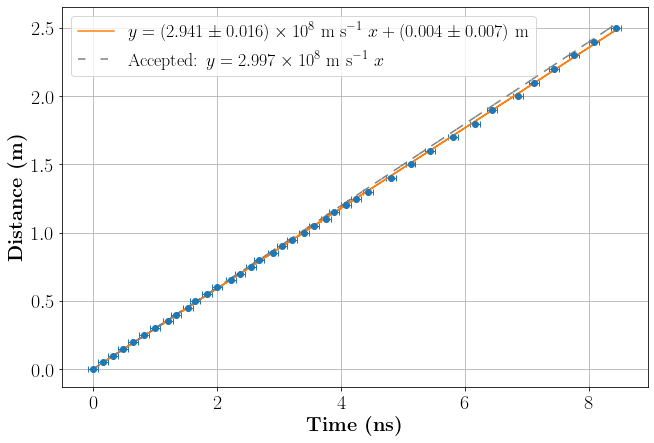

In [92]:
fig = plt.figure(figsize=(10.5,7))
ax = fig.add_subplot(111)

# New data - 21/06/21
ax.errorbar(
    air_data2['t'] * 1e9, 
    air_data2['x'], 
    marker='o',
    linestyle='',
    xerr=air_dt * 1e9,
    yerr=air_dx,
    capsize=3,
    elinewidth=1
)
ax.plot(
    air_data2['t'] * 1e9, 
    line2(air_data2['t'], *beta), 
    label=(
        r'$y = ({0:.3f} \pm {1:.3f}) \times 10^8$ $\rm{{m}}$ $\rm{{s}}^{{-1}}$ $x'
        ' + ({2:.3f} \pm {3:.3f})$ m'
        .format(beta[0]/1e8, sd_beta[0]/1e8, beta[1], sd_beta[1])
    ),
)

ax.plot(  # accepted values
    air_data2['t'] * 1e9,
    line2(air_data2['t'], const.c / n_air, 0),
    linestyle=(0,(5,10)),
    color='gray',
    label=r'Accepted: $y = {0:.3f} \times 10^8$ $\rm{{m}}$ $\rm{{s}}^{{-1}}$ $x$'.format(const.c / n_air / 1e8)
)

lgd = ax.legend(fontsize=18)
lbl = ax.set(
    xlabel=r'\bf{Time (ns)}',
    ylabel=r'\bf{Distance (m)}',
)
ax.grid()

fig.savefig(fig_path + 'air.pdf', bbox_inches='tight')

In [96]:
(const.c / n_air - beta[0]) / sd_beta[0] # 3.6 sigma discrepancy

3.606606758603249

In [97]:
(const.c / n_air - beta[0]) / const.c * 100 # 1.9% error

1.8815989413093686

In [285]:
const.c * betainv[0]

1.0194629089985914

In [286]:
const.c * sd_inv[0]

0.005422144993596877

## In Acrylic: $\Delta x$ method
$$ n = \frac{c(\Delta x + l_m)}{c_a l_m}
    = \frac{n_a (\Delta x + l_m)}{l_m}$$

In [98]:
ac_data1 = read_csv('../data/20210531_acrylic.csv')
ac_data1['initial'] = ac_data1['initial'] * 1e-3
ac_data1['final'] = ac_data1['final'] * 1e-3

ac_data2 = read_csv('../data/20210621_acrylic_x.csv')
ac_data2['initial'] = ac_data2['initial'] * 1e-3
ac_data2['final'] = ac_data2['final'] * 1e-3

ac_l = 0.491  # rod length
ac_dl = 0.001  # rod length uncertainty

In [99]:
n_ac1 = (ac_data1['final'] - ac_data1['initial'] + ac_l) / (ac_l) * n_air
c_ac1 = const.c / n_ac1

n_ac2 = (ac_data2['final'] - ac_data2['initial'] + ac_l) / (ac_l) * n_air
c_ac2 = const.c / n_ac2

In [100]:
# standard error: standard deviation of indivdual measurements divided by sqrt(n)
se_n_ac2 = 1 / np.sqrt(len(ac_data2['initial'])) * n_air * np.sqrt(
    (5e-3 / ac_l) ** 2
    + (np.mean(ac_data2['final'] - ac_data2['initial']) / ac_l ** 2 * ac_dl) ** 2
)
print(np.mean(n_ac2))
print('SE: ' + str(se_n_ac2))
print('SD: ' + str(np.std(n_ac2)))

1.4362406779071901
SE: 0.0032333435651659913
SD: 0.004463327190333451


In [101]:
const.c / np.mean(n_ac2) * 1e-8

2.087341367025204

In [102]:
const.c * np.std(n_ac2) / (np.mean(n_ac2) ** 2) * 1e-8

0.0064867174577779374

Intercept method

$$x' = x + l_m \left( \frac{n_m}{n_a} - 1 \right) = \beta_0 x + \beta_1$$

$$n_m = n_a \left( \frac{\beta_1}{l_m} + 1 \right)$$

$$\delta n_m = n_a \sqrt{
    \left( \frac{\delta \beta_1}{l_m} \right)^2
    + \left( \frac{\beta_1}{l_m^2} \delta l_m \right)^2
}$$

In [103]:
ac1_beta, ac1_cov = curve_fit(
    line2,
    ac_data1['initial'], 
    ac_data1['final'], 
    sigma=5e-3 * np.ones(len(ac_data1['initial'])),
    p0=[1, 0.214],
    absolute_sigma=True,
)
ac1_sd_beta = np.sqrt(np.diag(ac1_cov))
n_ac1_fit = n_air * (ac1_beta[1] / ac_l + 1)
dn_ac1_fit = n_air * np.sqrt(
    (ac1_sd_beta[1] / ac_l) ** 2
    + (ac1_beta[1] / ac_l ** 2 * ac_dl) ** 2
)
print(n_ac1_fit)
print(dn_ac1_fit)
ac2_beta, ac2_cov = curve_fit(
    line2,
    ac_data2['initial'], 
    ac_data2['final'], 
    sigma=5e-3 * np.ones(len(ac_data2['initial'])),
    p0=[1, 0.214],
    absolute_sigma=True,
)
ac2_sd_beta = np.sqrt(np.diag(ac2_cov))
n_ac2_fit = n_air * (ac2_beta[1] / ac_l + 1)
dn_ac2_fit = n_air * np.sqrt(
    (ac2_sd_beta[1] / ac_l) ** 2
    + (ac2_beta[1] / ac_l ** 2 * ac_dl) ** 2
)
print(n_ac2_fit)
print(dn_ac2_fit)

1.4371843897526368
0.010036629730179629
1.3751240528445055
0.055610540116503154


In [109]:
print(ac1_beta)
print(ac1_sd_beta)
print(ac2_beta)
print(ac2_sd_beta)

[1.00397059 0.21446323]
[0.00542326 0.00490723]
[1.06060606 0.184     ]
[0.05504818 0.02729468]


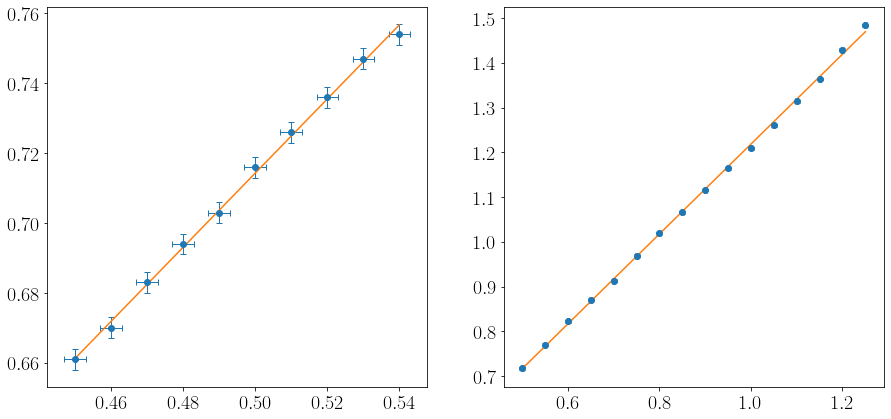

In [112]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121)
ax.errorbar(
    ac_data2['initial'],
    ac_data2['final'],
    marker='o',
    linestyle='',
#     label='New Data',
    xerr=3e-3,
    yerr=3e-3,
    capsize=3,
    elinewidth=1
)
ax.plot(
    ac_data2['initial'],
    line2(ac_data2['initial'], *ac2_beta)
)
ax1 = fig.add_subplot(122)
ax1.errorbar(
    ac_data1['initial'],
    ac_data1['final'],
    marker='o',
    linestyle='',
#     label='New Data',
    xerr=3e-3,
    yerr=3e-3,
    capsize=3,
    elinewidth=1
)
ax1.plot(
    ac_data1['initial'],
    line2(ac_data1['initial'], *ac1_beta)
)

## In Acrylic: $\Delta t$ Method
$$n = \frac{c}{c_m} 
    = \frac{c \Delta t}{2l_m} + \frac{c}{c_a}
    = \frac{c \Delta t}{2l_m} + n_a$$

In [113]:
ac_t_data = read_csv('../data/20210621_acrylic_t.csv')
ac_t_data['x'] = ac_t_data['x'] * 1e-3
ac_dx = 2e-3
ac_t_data['t'] = ac_t_data['t'] * 1e-9
ac_dt = 0.05 * 1e-9

In [114]:
n_ac_t = const.c * ac_t_data['t'] / (2 * ac_l) + n_air
se_n_ac_t = 1 / np.sqrt(len(ac_t_data['t'])) * const.c / 2 * np.sqrt(
    (ac_dt / ac_l) ** 2
    + (np.mean(ac_t_data['t']) / ac_l ** 2 * ac_dl) ** 2
)
print(np.mean(n_ac_t))
print('SE: ' + str(se_n_ac_t))
print('SD: ' + str(np.std(n_ac_t)))

1.424625235744373
SE: 0.0062416382695099255
SD: 0.009158629063136433


In [115]:
const.c / np.mean(n_ac_t) * 1e-8

2.1043601536607426

In [116]:
const.c * np.std(n_ac_t) / (np.mean(n_ac_t) ** 2) * 1e-8

0.013528508115015433

<ipython-input-279-aa6bb76ae9d4>:7: RuntimeWarning: divide by zero encountered in true_divide
  return const.c / n_m * 1e8


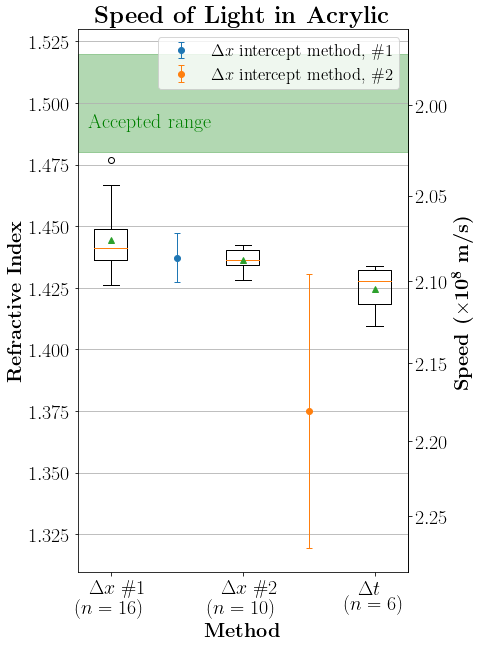

In [279]:
fig = plt.figure(figsize=(13, 10))

def c2n(c_m):
    return const.c / c_m * 1e-8

def n2c(n_m):
    return const.c / n_m * 1e8

ax1 = fig.add_subplot(121)
bpl = ax1.boxplot(
    [n_ac1, n_ac2, n_ac_t], 
    widths=0.5, 
    labels=[
        r'$\Delta x$ \#1 \\ ($n={}$)'.format(len(n_ac1)), 
        r'$\Delta x$ \#2 \\ ($n={}$)'.format(len(n_ac2)), 
        r'$\Delta t$ \\ ($n={}$)'.format(len(n_ac_t))
    ], 
    showmeans=True,
    positions=[1, 3, 5]
)
ax1.errorbar(
    [2],
    [n_ac1_fit],
    yerr=dn_ac1_fit,
    marker='o',
    linestyle='',
    capsize=3,
    elinewidth=1,
    label=r'$\Delta x$ intercept method, \#1',
)
ax1.errorbar(
    [4],
    [n_ac2_fit],
    yerr=dn_ac2_fit,
    marker='o',
    linestyle='',
    capsize=3,
    elinewidth=1,
    label=r'$\Delta x$ intercept method, \#2',
)
ax1.text(0.65, 1.49, 'Accepted range', color='g')
ax1.fill_between([0.5, 5.5], [1.48, 1.48], [1.52, 1.52], color='g', alpha=0.3)
ax1.legend(fontsize='small')
ax1.set_xlim(0.5, 5.5)
ax1.grid(axis='y')
ax2 = ax1.secondary_yaxis('right', functions=(c2n, n2c))
lbl = ax1.set(
    ylabel=r'\bf{Refractive Index}',
    title=r'\bf{Speed of Light in Acrylic}',
    xlabel=r'\bf{Method}'
)
lbl = ax2.set_ylabel(r'\bf{Speed ($\bf{\times 10^8}$ m/s)}')
fig.savefig(fig_path + 'acrylic.pdf', bbox_inches='tight')

## In Water: $\Delta x$ method
$$ n = \frac{c(\Delta x + l_m)}{c_a l_m}
    = \frac{n_a (\Delta x + l_m)}{l_m}$$

In [195]:
w_data1 = read_csv('../data/20210531_water.csv')
w_data1['initial'] = w_data1['initial'] * 1e-3
w_data1['final'] = w_data1['final'] * 1e-3

w_data2 = read_csv('../data/20210621_water_x.csv')
w_data2['initial'] = w_data2['initial'] * 1e-3
w_data2['final'] = w_data2['final'] * 1e-3

w_l = 0.513  # rod length
w_dl = 0.002  # rod length uncertainty

In [204]:
n_w1 = (w_data1['final'] - w_data1['initial'] + w_l) / (w_l) * n_air
c_w1 = const.c / n_w1

n_w2 = (w_data2['final'] - w_data2['initial'] + w_l) / (w_l) * n_air
c_w2 = const.c / n_w2

In [205]:
# standard error: standard deviation of indivdual measurements divided by sqrt(n)
se_n_w2 = 1 / np.sqrt(len(w_data2['initial'])) * n_air * np.sqrt(
    (5e-3 / w_l) ** 2
    + (np.mean(w_data2['final'] - w_data2['initial']) / w_l ** 2 * w_dl) ** 2
)
print(np.mean(n_w2))
print('SE: ' + str(se_n_w2))
print('SD: ' + str(np.std(n_w2)))

1.2286033990414236
SE: 0.0030958153159760093
SD: 0.004399072545782452


In [295]:
const.c / np.mean(n_w2) * 1e-8

2.440107672125138

In [296]:
const.c * np.std(n_w2) / (np.mean(n_w2) ** 2) * 1e-8

0.008736920862805546

<ipython-input-203-85bde094c288>:7: RuntimeWarning: divide by zero encountered in true_divide
  return const.c / n_m * 1e8


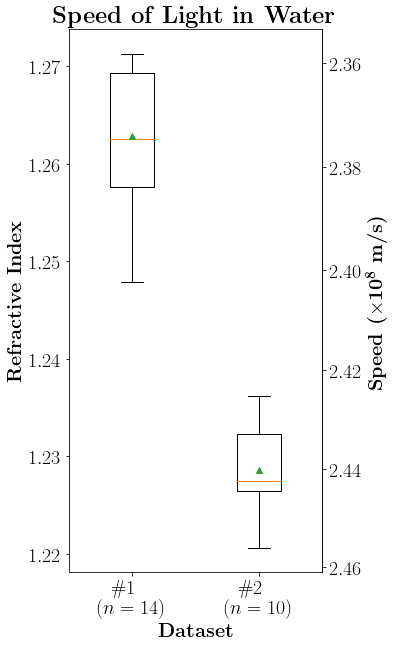

In [203]:
fig = plt.figure(figsize=(10, 10))

def c2n(c_m):
    return const.c / c_m * 1e-8

def n2c(n_m):
    return const.c / n_m * 1e8

ax1 = fig.add_subplot(121)
bpl = ax1.boxplot(
    [n_w1, n_w2], 
    widths=0.35, 
    labels=[r'\#1 \\ ($n={0}$)'.format(len(n_w1)), r'\#2 \\ ($n={0}$)'.format(len(n_w2))], 
    showmeans=True)
ax2 = ax1.secondary_yaxis('right', functions=(c2n, n2c))
lbl = ax1.set(
    ylabel=r'\bf{Refractive Index}',
    title=r'\bf{Speed of Light in Water}',
    xlabel=r'\bf{Dataset}'
)
lbl = ax2.set_ylabel(r'\bf{Speed ($\bf{\times 10^8}$ m/s)}')

$$x' = x + l_m \left( \frac{n_m}{n_a} - 1 \right) = \beta_0 x + \beta_1$$

$$n_m = n_a \left( \frac{\beta_1}{l_m} + 1 \right)$$

$$\delta n_m = n_a \sqrt{
    \left( \frac{\delta \beta_1}{l_m} \right)^2
    + \left( \frac{\beta_1}{l_m^2} \delta l_m \right)^2
}$$

In [214]:
w1_beta, w1_cov = curve_fit(
    line2,
    w_data1['initial'], 
    w_data1['final'], 
    sigma=5e-3 * np.ones(len(w_data1['initial'])),
    p0=[1, 0.214],
    absolute_sigma=True,
)
w1_sd_beta = np.sqrt(np.diag(w1_cov))
n_w1_fit = n_air * (w1_beta[1] / w_l + 1)
dn_w1_fit = n_air * np.sqrt(
    (w1_sd_beta[1] / w_l) ** 2
    + (w1_beta[1] / w_l ** 2 * w_dl) ** 2
)
print(n_w1_fit)
print(dn_w1_fit)
w2_beta, w2_cov = curve_fit(
    line2,
    w_data2['initial'], 
    w_data2['final'], 
    sigma=5e-3 * np.ones(len(w_data2['initial'])),
    p0=[1, 0.214],
    absolute_sigma=True,
)
w2_sd_beta = np.sqrt(np.diag(w2_cov))
n_w2_fit = n_air * (w2_beta[1] / w_l + 1)
dn_w2_fit = n_air * np.sqrt(
    (w2_sd_beta[1] / w_l) ** 2
    + (w2_beta[1] / w_l ** 2 * w_dl) ** 2
)
print(n_w2_fit)
print(dn_w2_fit)

1.2696681962377265
0.011028910827087686
1.302431983734235
0.0564479425252503


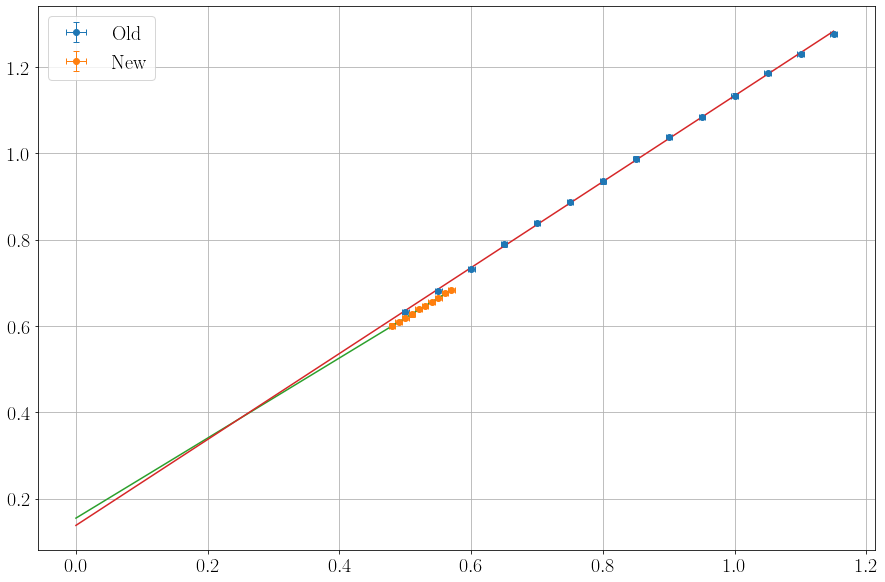

In [219]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.errorbar(
    w_data1['initial'],
    w_data1['final'],
    marker='o',
    linestyle='',
#     label='New Data',
    xerr=5e-3,
    yerr=5e-3,
    capsize=3,
    elinewidth=1,
    label='Old'
)
ax.errorbar(
    w_data2['initial'],
    w_data2['final'],
    marker='o',
    linestyle='',
#     label='New Data',
    xerr=5e-3,
    yerr=5e-3,
    capsize=3,
    elinewidth=1,
    label='New'
)
ax.plot(
    [0, np.max(w_data2['initial'])],
    line2(np.array([0, np.max(w_data2['initial'])]), *w2_beta)
)
ax.plot(
    [0, np.max(w_data1['initial'])],
    line2(np.array([0, np.max(w_data1['initial'])]), *w1_beta)
)
ax.legend()
ax.grid()

## In Water: $\Delta t$ Method
$$n = \frac{c}{c_m} 
    = \frac{c \Delta t}{2l_m} + \frac{c}{c_a}
    = \frac{c \Delta t}{2l_m} + n_a$$

In [222]:
w_t_data = read_csv('../data/20210621_water_t.csv')
w_t_data['x'] = w_t_data['x'] * 1e-3
w_dx = 2e-3
w_t_data['t'] = w_t_data['t'] * 1e-9
w_dt = 0.05 * 1e-9

In [223]:
n_w_t = const.c * w_t_data['t'] / (2 * w_l) + n_air
se_n_w_t = 1 / np.sqrt(len(w_t_data['t'])) * const.c / 2 * np.sqrt(
    (w_dt / w_l) ** 2
    + (np.mean(w_t_data['t']) / w_l ** 2 * w_dl) ** 2
)
print(np.mean(n_w_t))
print('SE: ' + str(se_n_w_t))
print('SD: ' + str(np.std(n_w_t)))

1.2355901003700573
SE: 0.008451567539088304
SD: 0.003067664944589134


In [297]:
const.c / np.mean(n_w_t) * 1e-8

2.4263099705170235

In [298]:
const.c * np.std(n_w_t) / (np.mean(n_w_t) ** 2) * 1e-8

0.0060239281935271

<ipython-input-269-b464a812a2b5>:7: RuntimeWarning: divide by zero encountered in true_divide
  return const.c / n_m * 1e8


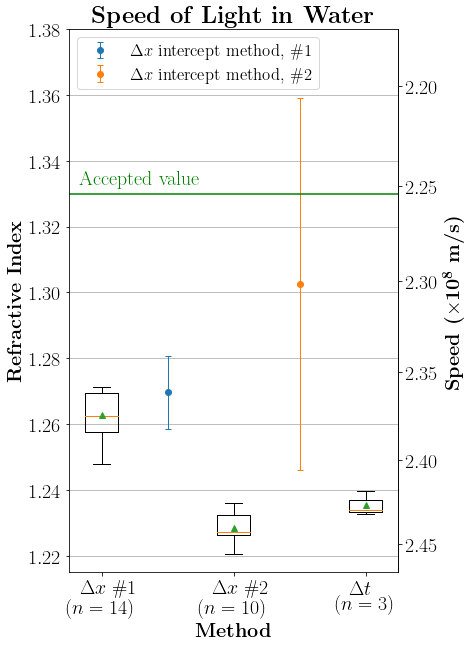

In [269]:
fig = plt.figure(figsize=(13, 10))

def c2n(c_m):
    return const.c / c_m * 1e-8

def n2c(n_m):
    return const.c / n_m * 1e8

ax1 = fig.add_subplot(121)
bpl = ax1.boxplot(
    [n_w1, n_w2, n_w_t], 
    widths=0.5, 
    labels=[
        r'$\Delta x$ \#1 \\ ($n={}$)'.format(len(n_w1)), 
        r'$\Delta x$ \#2 \\ ($n={}$)'.format(len(n_w2)), 
        r'$\Delta t$ \\ ($n={}$)'.format(len(n_w_t))
    ], 
    showmeans=True,
    positions=[1, 3, 5]
)
ax1.errorbar(
    [2],
    [n_w1_fit],
    yerr=dn_w1_fit,
    marker='o',
    linestyle='',
    capsize=3,
    elinewidth=1,
    label=r'$\Delta x$ intercept method, \#1',
)
ax1.errorbar(
    [4],
    [n_w2_fit],
    yerr=dn_w2_fit,
    marker='o',
    linestyle='',
    capsize=3,
    elinewidth=1,
    label=r'$\Delta x$ intercept method, \#2',
)
ax1.plot(
    [0.5, 5.5],
    [1.33, 1.33],
    'g',
)
ax1.text(0.65, 1.333, 'Accepted value', color='g')
ax1.legend(loc='upper left', fontsize='small')
ax1.set_xlim(0.5, 5.5)
ax1.set_ylim(1.215, 1.38)
ax1.grid(axis='y')
ax2 = ax1.secondary_yaxis('right', functions=(c2n, n2c))
lbl = ax1.set(
    ylabel=r'\bf{Refractive Index}',
    title=r'\bf{Speed of Light in Water}',
    xlabel=r'\bf{Method}'
)
lbl = ax2.set_ylabel(r'\bf{Speed ($\bf{\times 10^8}$ m/s)}')
fig.savefig(fig_path + 'water.pdf', bbox_inches='tight')